# clover-on-clover connected proton charge radius

In [1]:
import numpy as np
import pandas as pd
import gvar as gv
import matplotlib.pyplot as plt
%matplotlib notebook
from tqdm import tqdm_notebook as tqdm
import pcr_lib as pcr

# switches

In [2]:
switches = dict()
# fitting options
switches['fit'] = dict()
switches['fit']['clist']   = ['nucleon','dnucleon','gV','dgV']
switches['fit']['snk_src'] = ['SS']
switches['fit']['mom']     = [0,1] # n in 2*n*pi/L
switches['fit']['nstate']  = 2
switches['fit']['T_3pt']   = [10,14] # t_snk for 3pt
# plotting options
switches['plot'] = dict()
switches['plot']['correlator'] = False

# read csv file into dataframe
## ensemble information
+ 0.12fm lattice spacing
+ pion mass 400 MeV
+ isoclover

## configuration information
+ 1000 to 2950 skip 10 (196 configurations)
    + configuration 1470 is missing for baryon 2pt tsrc 48, idx = 47
+ two point correlation function
    + `bar_s22_SS_tsrc_[0,48].dat.[re,im]`
    + two sources at `[0,48]`
    + each line contains:
        + individual momentum `[0,1,-1,2,-2]`
        + individual time slice
        + array of z-dependence
        + *e.g.* `bar_s22_S0src_S0_px0_py0_pz0_t0_re`
+ three point correlation function
    + `barff_s22_SS_g8_T[10,14]_tsrc_[0,48].dat.[re,im]`
    + `g8` corresponds to the `V4` current insertion
    + `T[10,14]` is snk location
    + two sources at `[0,48]`
    + each line contains:
        + individual momentum transfer (snk at zero momentum) `[0,1,-1,2,-2]`
        + individual time slice
        + array of z-dependence at current insertion
        + *e.g.* `barff_s2_S0src_S0snk_T10_px0_py0_pz0_g8_t0_re`

## strategy
+ read zero momentum spatial correlator
+ perform source average
+ construct two and three point (with momentum transfer)
+ construct moment correlators

## notes
+ read SS src snk

In [3]:
zdata = pcr.read_csv(switches)

2pt: bar_s22_S0src_S0_px0_py0_pz0_re (195, 96, 32)
3pt: barff_s2_S0src_S0snk_T10_px0_py0_pz0_g8_re (195, 96, 32)
3pt: barff_s2_S0src_S0snk_T14_px0_py0_pz0_g8_re (195, 96, 32)


# construct two and three point correlators
+ Lattice 2016 proceedings @ https://arxiv.org/pdf/1610.02354.pdf
+ project to definite momentum

In [4]:
data = dict()
# two point correlation function
if 'nucleon' in switches['fit']['clist']:
    for snk_src in switches['fit']['snk_src']:
        snk = snk_src[0]
        src = snk_src[1]
        for n in switches['fit']['mom']:
            k = 2.*np.pi*n/32
            pos = zdata['bar_s22_%s0src_%s0_px0_py0_pz0_re' %(src,snk)]*np.cos(k*np.arange(32))
            neg = zdata['bar_s22_%s0src_%s0_px0_py0_pz0_re' %(src,snk)]*np.cos(-k*np.arange(32))
            data['nucleon_%s_q%s' %(str(snk_src),str(n))] = np.sum((pos+neg)/2,axis=2) # mom avg & project to 3 momentum
# gV correlation function
if 'gV' in switches['fit']['clist']:
    for snk_src in switches['fit']['snk_src']:
        snk = snk_src[0]
        src = snk_src[1]
        for n in switches['fit']['mom']:
            k = 2.*np.pi*n/32
            for T in switches['fit']['T_3pt']:
                pos = zdata['barff_s2_%s0src_%s0snk_T%s_px0_py0_pz0_g8_re' %(src,snk,str(T))]*np.cos(k*np.arange(32))
                neg = zdata['barff_s2_%s0src_%s0snk_T%s_px0_py0_pz0_g8_re' %(src,snk,str(T))]*np.cos(-k*np.arange(32))
                data['gV_%s_T%s_q%s' %(str(snk_src),str(T),str(n))] = np.sum((pos+neg)/2,axis=2) # mom avg & project to 3 momentum
data.keys()

dict_keys(['nucleon_SS_q0', 'nucleon_SS_q1', 'gV_SS_T10_q0', 'gV_SS_T14_q0', 'gV_SS_T10_q1', 'gV_SS_T14_q1'])

# construct moments of correlation functions

<IPython.core.display.Javascript object>


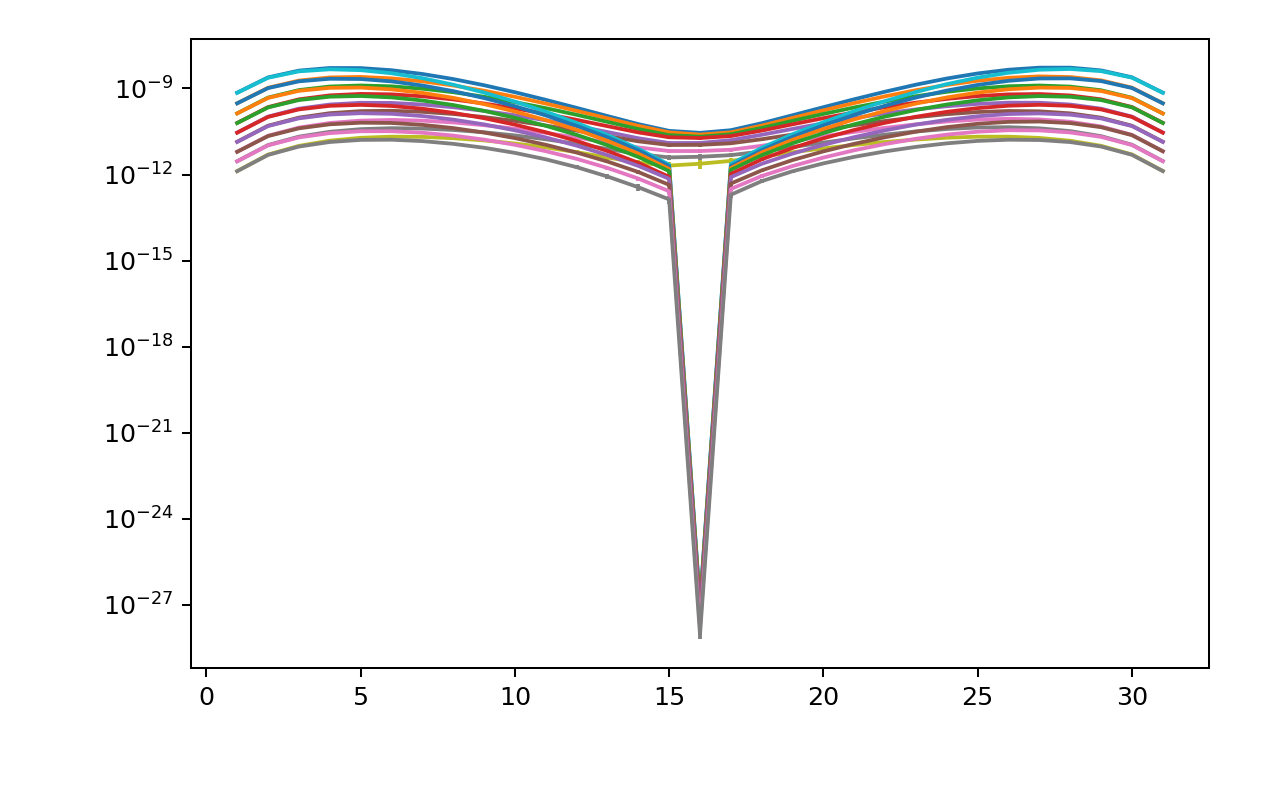

<IPython.core.display.Javascript object>


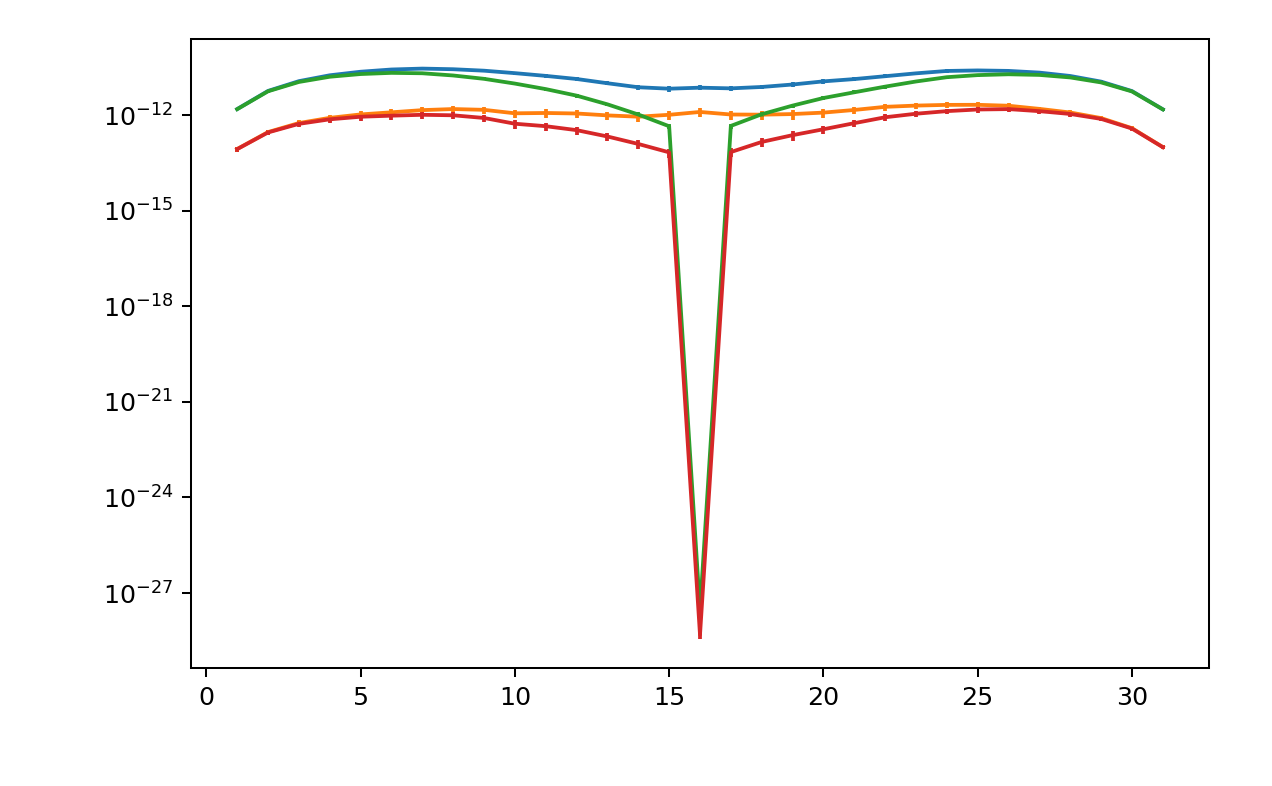

dict_keys(['nucleon_SS_q0', 'nucleon_SS_q1', 'gV_SS_T10_q0', 'gV_SS_T14_q0', 'gV_SS_T10_q1', 'gV_SS_T14_q1', 'dnucleon_SS_q0', 'dgV_SS_T10_q0', 'dgV_SS_T14_q0', 'dnucleon_SS_q1', 'dgV_SS_T10_q1', 'dgV_SS_T14_q1'])


In [5]:
# two point moment data
z = np.roll(np.arange(32)-15,17)
rz2 = z**2
# apply moment
# output is Ncf * T * Z
if 'dnucleon' in switches['fit']['clist']:
    for q in switches['fit']['mom']:
        for snk_src in switches['fit']['snk_src']:
            snk = snk_src[0]
            src = snk_src[1]
            if q == 0:
                D = 0.5*rz2
            else:
                k = 2.*np.pi*q/32
                D = z/(2.*k)*np.sin(k*np.arange(32))
            if 'dnucleon' in switches['fit']['clist']:
                temp = D*zdata['bar_s22_%s0src_%s0_px0_py0_pz0_re' %(src,snk)]
                # UNCOMMENT TO PLOT Z DEPENDENCE
                pcr.plot_2pt_z(temp,title='2pt') #title='dnucleon_%s_q%s' %(snk_src,str(q)))
                # project to 3 momentum
                data['dnucleon_%s_q%s' %(snk_src,str(q))] = np.sum(temp,axis=2)
            if 'dgV' in switches['fit']['clist']:
                for T in switches['fit']['T_3pt']:
                    temp = D*zdata['barff_s2_%s0src_%s0snk_T%s_px0_py0_pz0_g8_re' %(src,snk,str(T))]
                    # UNCOMMENT TO PLOT Z DEPENDENCE
                    pcr.plot_3pt_z(temp,title='3pt') #title='dgV_%s_T%s_q%s' %(snk_src,str(T),str(q)))
                    # project 3 momentum
                    data['dgV_%s_T%s_q%s' %(snk_src,str(T),str(q))] = np.sum(temp,axis=2)
print(data.keys())

# construct correlated dataset

In [6]:
gvdata = gv.dataset.avg_data(data)
for k in gvdata.keys():
    print(k,np.shape(gvdata[k]))

nucleon_SS_q0 (96,)
nucleon_SS_q1 (96,)
gV_SS_T10_q0 (96,)
gV_SS_T14_q0 (96,)
gV_SS_T10_q1 (96,)
gV_SS_T14_q1 (96,)
dnucleon_SS_q0 (96,)
dgV_SS_T10_q0 (96,)
dgV_SS_T14_q0 (96,)
dnucleon_SS_q1 (96,)
dgV_SS_T10_q1 (96,)
dgV_SS_T14_q1 (96,)


# plot correlation function

In [7]:
if switches['plot']['correlator']:
    fig = plt.figure('meff',figsize=(7,4.326237))
    ax = plt.axes([0.15,0.15,0.8,0.8])
    x = np.arange(2,18)
    meff = np.log(gvdata['dnucleon_q1']/np.roll(gvdata['dnucleon_q1'],-1))[x]
    ax.errorbar(x,y=[i.mean for i in meff],yerr=[i.sdev for i in meff])
    meff = np.log(gvdata['nucleon_q1']/np.roll(gvdata['nucleon_q1'],-1))[x]
    ax.errorbar(x,y=[i.mean for i in meff],yerr=[i.sdev for i in meff])
    plt.draw()
    fig = plt.figure('correlator',figsize=(7,4.326237))
    ax = plt.axes([0.15,0.15,0.8,0.8])
    x = np.arange(0,16)
    meff = gvdata['gV_T10_q0'][x]
    ax.errorbar(x,y=[i.mean for i in meff],yerr=[i.sdev for i in meff])
    meff = gvdata['dgV_T10_q0'][x]
    ax.errorbar(x,y=[i.mean for i in meff],yerr=[i.sdev for i in meff])
    meff = gvdata['gV_T14_q0'][x]
    ax.errorbar(x,y=[i.mean for i in meff],yerr=[i.sdev for i in meff])
    meff = gvdata['dgV_T14_q0'][x]
    ax.errorbar(x,y=[i.mean for i in meff],yerr=[i.sdev for i in meff])
    plt.draw()

# fit correlators
+ blahblah... I'm too lazy for this... I will regret it later